In [125]:
#import required modules and load the metadata
import time
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
##Import any other packages you may need here
from itertools import chain
import cv2

def load_xray_data():
    """ load data and preprocess required fields"""
    df = pd.read_csv('data/Data_Entry_2017.csv')

    def convert(x):
        """assume that the first number is incorrect for ages above 110"""
        if x > 110:
            x=int(str(x)[1:-1])
        return x

    # convert ages above 110 to lower ages by assuming and non-random consisting error in the data-collection process.
    df['Patient Age'] = df['Patient Age'].apply(lambda x:convert(x))

    disease_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

    for label in disease_labels:
        df[label] = df['Finding Labels'].map(lambda x: 1 if label in x else 0)

    df['total_disease']=df[disease_labels].sum(axis=1)

    all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data','images*','*.png'))}
    print('Scans found:', len(all_image_paths), ', Total Headers', df.shape[0])
    df['path'] = df['Image Index'].map(all_image_paths.get)
    
    display(df.sample(3))
    return df,disease_labels


df, disease_labels = load_xray_data()

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,total_disease,path
46288,00011835_003.png,Atelectasis,3,11835,37,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,1,data\images\00011835_003.png
85312,00021031_001.png,No Finding,1,21031,48,F,PA,2544,3044,0.139,...,0,0,0,1,0,0,0,0,1,data\images\00021031_001.png
48422,00012278_000.png,No Finding,0,12278,67,F,PA,2992,2597,0.143,...,0,0,0,1,0,0,0,0,1,data\images\00012278_000.png


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings.**

## EDA

### Demographic data such as age, gender, patient position,etc. (as it is available)

#### Age

In [126]:
# Age distribution of all scans
print('Age distribution x-ray scan-wise')
display(df['Patient Age'].describe())
# Age distribution of all patients
print('Patient-wise Age distribution')
display(df.groupby(['Patient ID']).first()['Patient Age'].describe())
print('% scans for children:',len(df[df['Patient Age']<16])/len(df)*100,' %')
print('% scans for elderly:',len(df[df['Patient Age']>75])/len(df)*100,' %')

Age distribution x-ray scan-wise


count    112120.000000
mean         46.866357
std          16.605136
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max          95.000000
Name: Patient Age, dtype: float64

Patient-wise Age distribution


count    30805.000000
mean        46.076773
std         16.704754
min          1.000000
25%         34.000000
50%         48.000000
75%         58.000000
max         95.000000
Name: Patient Age, dtype: float64

% scans for children: 3.539065287192294  %
% scans for elderly: 2.438458794149126  %


#### Gender

In [127]:
# Gender distribution by scan
n_scans_gender=df.groupby(['Patient Gender']).size()
n_scans_gender_per=df.groupby(['Patient Gender']).size()/len(df)
print('Gender frequency and proportion (x-ray scan-wise)')
display(n_scans_gender)
display(n_scans_gender_per)
n_patients_gender=df.groupby(['Patient Gender'])['Patient ID'].unique().apply(lambda x:len(x))
n_patients_gender_per=df.groupby(['Patient Gender'])['Patient ID'].unique().apply(lambda x:len(x))/len(df['Patient ID'].unique())
print('Gender frequency and proportion (patient-wise)')
display(n_patients_gender)
display(n_patients_gender_per)

Gender frequency and proportion (x-ray scan-wise)


Patient Gender
F    48780
M    63340
dtype: int64

Patient Gender
F    0.43507
M    0.56493
dtype: float64

Gender frequency and proportion (patient-wise)


Patient Gender
F    14175
M    16630
Name: Patient ID, dtype: int64

Patient Gender
F    0.460153
M    0.539847
Name: Patient ID, dtype: float64

#### The x-ray views taken (i.e. view position)
Definitions from [here](https://radiopaedia.org/articles/radiographic-positioning-terminology?lang=gb).

Relevant terms of relations
* anterior is towards the front of the body (Latin: before)
* posterior is towards the back of the body (Latin: after)

Relevant planes
* the coronal plane: vertical plane perpendicular to the median plane
divides the body into anterior and posterior parts

Projections
* antero-posterior (AP): central ray passes, perpendicular to the coronal plane, from anterior to posterior.
* postero-anterior (PA): central ray passes, perpendicular to the coronal plane, from posterior to anterior.
depending on the anatomic segment to radiograph, synonyms can be used, for example: occipito-frontal (skull); dorso-ventral (thorax); dorso-palmar (hand)

In [128]:
print('View position frequency and proportion (x-ray scan-wise)')
display(df.groupby(['View Position'])['Image Index'].count())
display(df.groupby(['View Position'])['Image Index'].count()/len(df))

View position frequency and proportion (x-ray scan-wise)


View Position
AP    44810
PA    67310
Name: Image Index, dtype: int64

View Position
AP    0.399661
PA    0.600339
Name: Image Index, dtype: float64

### Number of pneumonia vs non-pneumonia cases:
https://www.radiologyinfo.org/en/info/pneumonia

Pneumonia is an infection that causes inflammation in one or both of the lungs. It can be caused by a virus, bacteria, fungi or other germs. The infection is usually acquired when a person breathes in air carrying germs.
Patients with pneumonia could have the following symptoms:
* cough that produces phlegm or sometimes blood
* fever
* shortness of breath or difficulty breathing
* chills or shaking
* fatigue
* sweating
* chest or muscle pain

Assessment by Chest x-ray: An x-ray exam will allow your doctor to see your lungs, heart and blood vessels to help determine if you have pneumonia. When interpreting the x-ray, the radiologist will look for white spots in the lungs (called infiltrates) that identify an infection. This exam will also help determine if you have any complications related to pneumonia such as abscesses or pleural effusions (fluid surrounding the lungs).

In [129]:
print('Pneumonia frequency and proportion (x-ray scan-wise)')
display(df.groupby(['Pneumonia']).size())
display(df.groupby(['Pneumonia']).size()/len(df))
display(df.groupby(['Pneumonia','Patient Gender']).size()/len(df))
print('X-ray scan-wise age stats by presence of Pneumonia')
display(df.groupby(['Pneumonia'])['Patient Age'].describe())
print('% scans for children:',df[df['Patient Age']<16].groupby(['Pneumonia']).size()/len(df)*100,' %')


print('Pneumonia frequency and proportion (patient-wise)')
display(df.groupby(['Patient ID']).first().groupby(['Pneumonia'])['Patient Age'].size())
display(df.groupby(['Patient ID']).first().groupby(['Pneumonia'])['Patient Age'].size()/len(df['Patient ID'].unique()))
display(df.groupby(['Pneumonia','Patient Gender']).size()/len(df['Patient ID'].unique()))
print('Patient-wise age stats by presence of Pneumonia')
display(df.groupby(['Patient ID']).first().groupby(['Pneumonia'])['Patient Age'].describe())

Pneumonia frequency and proportion (x-ray scan-wise)


Pneumonia
0    110689
1      1431
dtype: int64

Pneumonia
0    0.987237
1    0.012763
dtype: float64

Pneumonia  Patient Gender
0          F                 0.429781
           M                 0.557456
1          F                 0.005289
           M                 0.007474
dtype: float64

X-ray scan-wise age stats by presence of Pneumonia


,count,mean,std,min,25%,50%,75%,max
Pneumonia,,,,,,,,
0,110689.0,46.895139,16.589042,1.0,35.0,49.0,59.0,95.0
1,1431.0,44.640112,17.670679,1.0,31.0,46.0,59.0,90.0


% scans for children: Pneumonia
0    3.463254
1    0.075812
dtype: float64  %
Pneumonia frequency and proportion (patient-wise)


Pneumonia
0    30627
1      178
Name: Patient Age, dtype: int64

Pneumonia
0    0.994222
1    0.005778
Name: Patient Age, dtype: float64

Pneumonia  Patient Gender
0          F                 1.564259
           M                 2.028956
1          F                 0.019250
           M                 0.027203
dtype: float64

Patient-wise age stats by presence of Pneumonia


,count,mean,std,min,25%,50%,75%,max
Pneumonia,,,,,,,,
0,30627.0,46.090606,16.677941,1.0,34.00,48.0,58.00,95.0
1,178.0,43.696629,20.730940,1.0,30.25,47.0,59.75,84.0


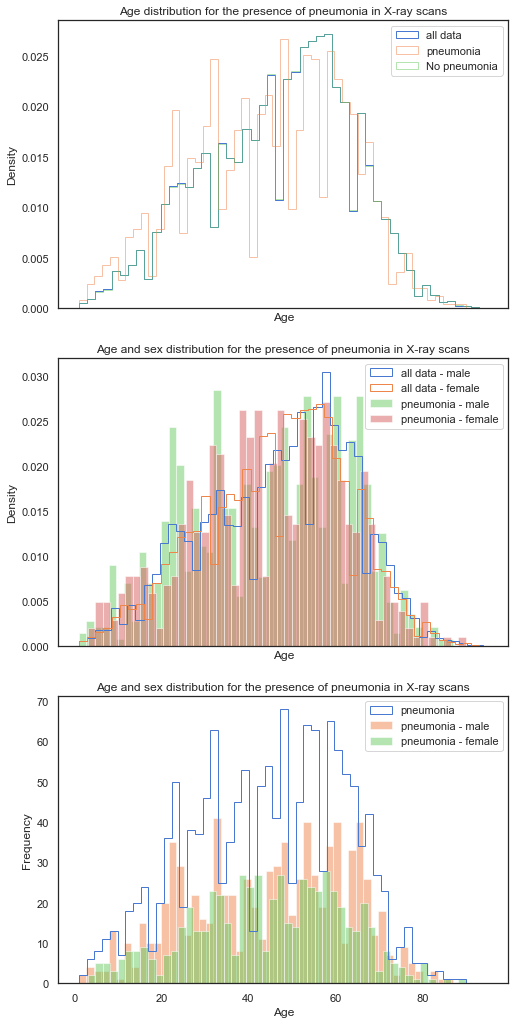

In [130]:
f, axes = plt.subplots(3, 1, figsize=(7, 14), sharex=True)
f.tight_layout(h_pad=4)
axes[0].hist(df['Patient Age'], bins=50, density=True,label='all data',histtype=u'step')
axes[0].hist(df[df['Pneumonia']==1]['Patient Age'], bins=50, density=True,alpha=0.5,label='pneumonia',histtype=u'step')
axes[0].hist(df[df['Pneumonia']==0]['Patient Age'], bins=50, density=True,alpha=0.5,label='No pneumonia',histtype=u'step')
axes[0].set_ylabel('Density')
axes[0].set_xlabel('Age')
axes[0].set_title('Age distribution for the presence of pneumonia in X-ray scans')
axes[0].legend()

axes[1].hist(df[df['Patient Gender']=='M']['Patient Age'], bins=50, density=True,label='all data - male',histtype=u'step')
axes[1].hist(df[df['Patient Gender']=='F']['Patient Age'], bins=50, density=True,label='all data - female',histtype=u'step')
axes[1].hist(df[(df['Pneumonia']==1) & (df['Patient Gender']=='M')]['Patient Age'],alpha=0.5, bins=50, density=True,label='pneumonia - male')
axes[1].hist(df[(df['Pneumonia']==1) & (df['Patient Gender']=='F')]['Patient Age'],alpha=0.5, bins=50, density=True,label='pneumonia - female')
axes[1].set_ylabel('Density')
axes[1].set_xlabel('Age')
axes[1].set_title('Age and sex distribution for the presence of pneumonia in X-ray scans')
axes[1].legend()

axes[2].hist(df[df['Pneumonia']==1]['Patient Age'], bins=50,label='pneumonia',histtype=u'step')
axes[2].hist(df[(df['Pneumonia']==1) & (df['Patient Gender']=='M')]['Patient Age'],alpha=0.5, bins=50, label='pneumonia - male')
axes[2].hist(df[(df['Pneumonia']==1) & (df['Patient Gender']=='F')]['Patient Age'],alpha=0.5, bins=50, label='pneumonia - female')
axes[2].set_ylabel('Frequency')
axes[2].set_xlabel('Age')
axes[2].set_title('Age and sex distribution for the presence of pneumonia in X-ray scans')
axes[2].legend()

### The distribution of other diseases that are comorbid with pneumonia
https://www.radiologyinfo.org/en/info/pneumonia

People with existing health problems are also at increased risk. Risk factors and circumstances that may increase a person's chances of developing pneumonia include:

having illnesses such as emphysema, HIV/AIDS or other lung diseases or conditions that affect the immune system
having the flu
exposure to and inhalation of various chemicals
smoking or excessive drinking
a prolonged stay in the hospital or intensive care
recent surgery
recent injury
Pneumonia can sometimes lead to serious complications, such as respiratory system failure, spread of infections, fluid surrounding the lungs, abscesses or uncontrolled inflammation throughout the body (sepsis).

Text(0.5, 1.0, 'Diseases comorbid with pneumonia (n=1431 cases)')

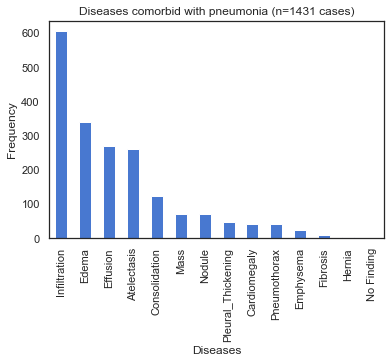

In [131]:
comorbidities_labels=list(disease_labels.copy())
comorbidities_labels.remove('Pneumonia')
df_pneumonia=df[df.Pneumonia==1]
df_pneumonia[comorbidities_labels].sum().sort_values(ascending=False).plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Diseases')
plt.title('Diseases comorbid with pneumonia (n={} cases)'.format(len(df_pneumonia)))

#### Number of disease per patient

In [132]:
data_with_disease=df[df['Finding Labels']!='No Finding'].groupby(['Patient ID'])['total_disease'].sum().describe()
print('# Patients without disease:',df[df['Finding Labels']=='No Finding']['Patient ID'].unique().size)

print('# Diseases per patient:')
print(data_with_disease)

# Patients without disease: 24907
# Diseases per patient:
count    14402.000000
mean         5.636439
std         11.696205
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        254.000000
Name: total_disease, dtype: float64


### Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

C:\Users\mauro\Documents\udacity\AIHCND_C2_Starter\venv\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


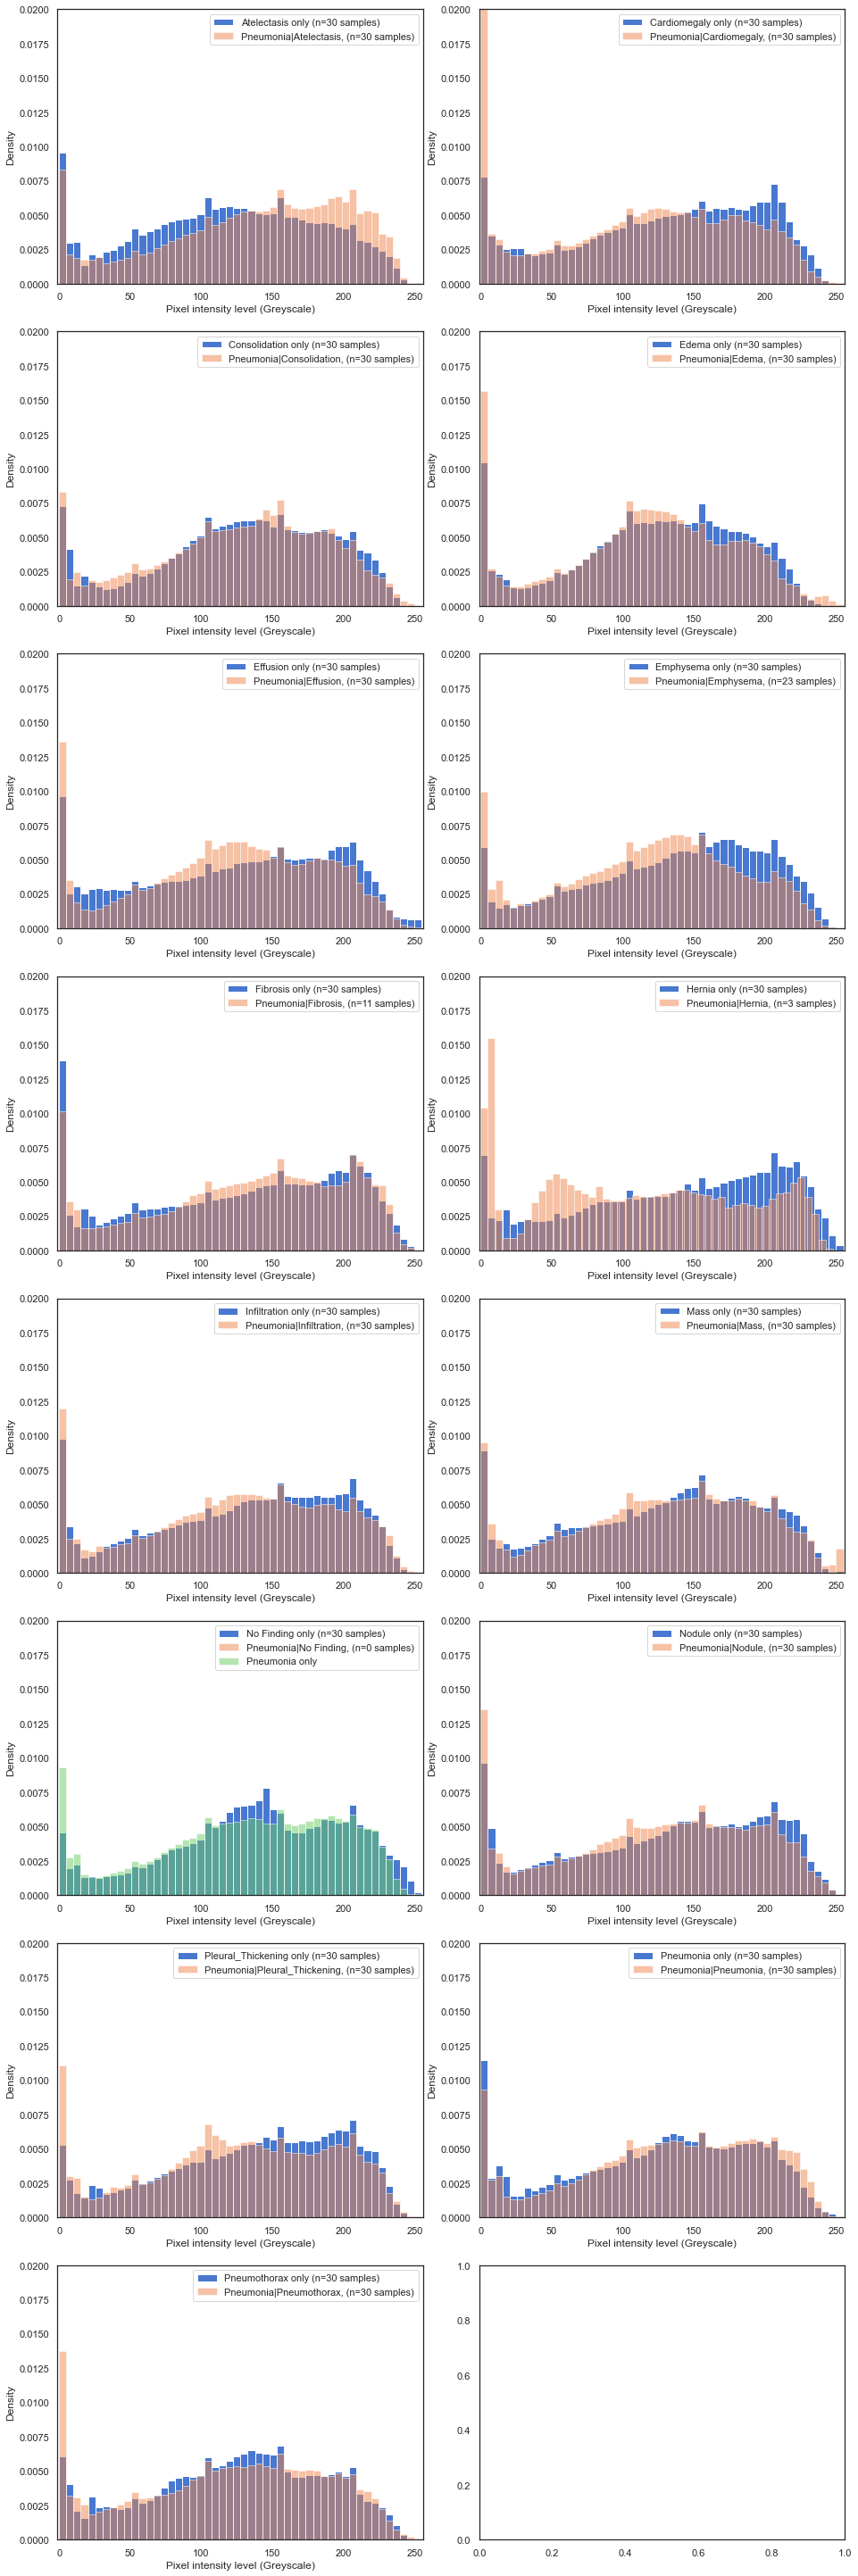

processing time:50.30602478981018 seconds


In [134]:
# In this section we review the overlap of the distribution of pixel intensities for each disease,
# and for both the disease and the presence of pneumonia, in greyscale.
# Please note I've moved all the images from their (12) folders into a unique folder 'data/images/' to make facilitate the script.
start_time = time.time()
directory = os.path.join('.','data')
fig,ax = plt.subplots(math.ceil(len(disease_labels)/2),2,figsize=(13,40))
plt.tight_layout(w_pad=3,h_pad=3)
axes = ax.ravel()
axes_count = 0
n_samples = 30

save_pneumonia=[]
save_find_pos=-1

for disease in disease_labels:
    
    img_data=[]


    find_disease = df[df['Finding Labels']==disease]

    if len(find_disease)>n_samples:
        find_disease=find_disease.iloc[0:n_samples]

    for index, row in find_disease.iterrows():

        img = cv2.imread(row['path'],0)
        if img is not None:
            img_data=np.append(img_data,img.reshape(-1))

    axes[axes_count].hist(img_data, bins=50, density=True,label='{} only (n={} samples)'.format(disease,len(find_disease)))
    axes[axes_count].set_ylabel('Density')
    axes[axes_count].set_xlabel('Pixel intensity level (Greyscale)')
    axes[axes_count].set_ylim([0, 0.02])
    axes[axes_count].set_xlim([-1, 256])
    axes[axes_count].legend()
    
    if disease == 'No Finding':
        save_find_pos=axes_count


    img_data=[]

    find_pneumonia_disease = df[df['Finding Labels'].apply(lambda x: disease in x and 'Pneumonia' in x)]

    if len(find_pneumonia_disease)>n_samples:
        find_pneumonia_disease=find_pneumonia_disease.iloc[0:n_samples]

    for index, row in find_pneumonia_disease.iterrows():

        img = cv2.imread(row['path'],0)
        if img is not None:
            img_data=np.append(img_data,img.reshape(-1))
    if disease=='Pneumonia':
        save_pneumonia=img_data.copy()
            
    axes[axes_count].hist(img_data, bins=50, density=True,alpha=0.5,label='Pneumonia|{}, (n={} samples)'.format(disease,len(find_pneumonia_disease)))
    axes[axes_count].set_ylabel('Density')
    axes[axes_count].set_xlabel('Pixel intensity level (Greyscale)')
    axes[axes_count].set_ylim([0, 0.02])
    axes[axes_count].set_xlim([-1, 256])
    axes[axes_count].legend()
    axes_count=axes_count+1


axes[save_find_pos].hist(save_pneumonia, bins=50, density=True,alpha=0.5,label='Pneumonia only')
axes[save_find_pos].legend()    
plt.show()


duration = time.time()-start_time
print('processing time:{} seconds'.format(duration))

## Discussion

From the EDA analysis it's possible to observe:

* The dataset population presents a median [Q1,Q3] age of  of 48 [34, 58] years (determined patient-wise), in a range of [1, 95] years. For patients with at least 1 disease the age median was 48 [58, 95] and 47 [59.75, 84.0] years for those with and without pneumonia, respectivel (i.e. not different from the population).

* The gender proportion is balanced (54% males).

* The pneumonia class/labels suffer from extreme data imbalance, as only 1% of the x-rays have pneumonia (0.05% of the patients).

* also note that only 3.5% of scans exist for children (<16 years old), and only 0.076% have pneumonia. A similar situation can be observed for the eldery with ou 2.44% of the scans belonging to patients > 75 years old of age.

* The pixel intensity distribution of the scans with pneumonia overlaps significantely with that of the other conditions, and even with that of absent diseases (i.e. label = 'No findings').

Based on these data, the model should be trained to detect pneumonia in adults patients (between 16 and 75 years old), and the label importance needs to be re-weighted to address the class imbalance.


